In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [10]:
patchsize = 8
visibleSize = patchsize*patchsize
hiddenSize = 25
learning_rate = 0.3
epochs = 2000
batch_size = 100
regul_weight = 0.0001
sparsity = 0.01
sparsity_weight = 2 #

In [4]:
def KL(rho, rho_j):
    return rho * tf.log(rho / rho_j) + (1 - rho) * tf.log((1 - rho) / (1 - rho_j))

In [5]:
def normalize(patches):
    patches -= np.mean(patches, axis=0)
    sd = 3*np.std(patches, axis=0)
    sd[sd < 0.00001] = 0.0001
    # patches = np.maximum(np.minimum(patches, std), -patches) / std
    for col in range(patches.shape[1]):
        for row in range(patches.shape[0]):
            val = patches[row, col]
            patches[row, col] = np.maximum(np.minimum(val, sd[col]), 
                                           -sd[col]) / sd[col]
    patches = (patches + 1) * 0.5
    return patches

In [6]:
def sampleImage(images, patchsize = 8):
    numpatches = 10000
    patches = np.zeros([patchsize*patchsize, numpatches])
    imgsize = 28
    numimg = 10
    for i in range(numpatches):
        r = np.random.randint(0, imgsize - patchsize)
        c = np.random.randint(0, imgsize - patchsize)
        idx = np.random.randint(0, numimg)
        a_patch = images[idx, :].reshape([28, 28])[r:r+patchsize, c:c+patchsize]
        patches[:, i] = a_patch.reshape([patchsize*patchsize,]);
    patches = normalize(patches)
    return patches

In [7]:
images, _ = mnist.train.next_batch(batch_size=10)
patches = sampleImage(images, patchsize).T

In [8]:
print(np.max(patches), np.min(patches))

1.0 0.220201449854


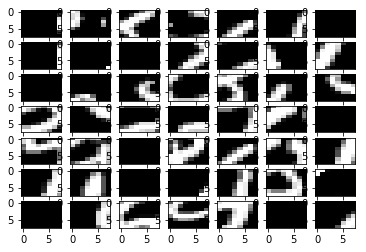

In [9]:
plt.figure()
for i in range(49):
    ax= plt.subplot(7, 7,i+1)
    im=ax.imshow(patches[np.random.randint(0, 10000), :].reshape([patchsize, patchsize]), cmap='gray', aspect='auto')

In [11]:
data = tf.placeholder(tf.float32, [None, visibleSize])
x = tf.placeholder(tf.float32, [None, visibleSize])
y = tf.placeholder(tf.float32, [None, visibleSize])

r  = np.sqrt(6) / np.sqrt(hiddenSize+visibleSize+1)
W1 = tf.Variable(tf.random_uniform([visibleSize, hiddenSize], -r, r), name='W1')
b1 = tf.Variable(tf.random_normal([hiddenSize]), name='b1')

W2 = tf.Variable(tf.random_uniform([hiddenSize, visibleSize], -r, r), name='W2')
b2 = tf.Variable(tf.random_normal([visibleSize]), name='b2')

hidden_out = tf.add(tf.matmul(x, W1), b1)
hidden_out = tf.nn.sigmoid(hidden_out)

activation = tf.nn.sigmoid(tf.add(tf.matmul(data, W1), b1))

rho = tf.reduce_mean(activation, 0)

y_ = tf.nn.sigmoid(tf.add(tf.matmul(hidden_out, W2), b2))

In [12]:
rho = tf.clip_by_value(rho, 1e-10, 0.9999999)
MSE = tf.reduce_mean(1/2 * tf.square(y_ - y))
regul = tf.reduce_sum(tf.square(W1)) + tf.reduce_sum(tf.square(W2))
penalty = tf.reduce_sum(KL(sparsity, rho))
loss = MSE + regul_weight * regul + sparsity_weight * penalty

In [13]:
optimiser = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)
init_op = tf.global_variables_initializer()

Epoch: 1 cost = 0.437
Epoch: 2 cost = 0.040
Epoch: 3 cost = 0.039
Epoch: 4 cost = 0.038
Epoch: 5 cost = 0.038
Epoch: 6 cost = 0.037
Epoch: 7 cost = 0.037
Epoch: 8 cost = 0.036
Epoch: 9 cost = 0.036
Epoch: 10 cost = 0.035
Epoch: 11 cost = 0.035
Epoch: 12 cost = 0.034
Epoch: 13 cost = 0.034
Epoch: 14 cost = 0.033
Epoch: 15 cost = 0.033
Epoch: 16 cost = 0.033
Epoch: 17 cost = 0.032
Epoch: 18 cost = 0.032
Epoch: 19 cost = 0.031
Epoch: 20 cost = 0.031
Epoch: 21 cost = 0.030
Epoch: 22 cost = 0.030
Epoch: 23 cost = 0.030
Epoch: 24 cost = 0.029
Epoch: 25 cost = 0.029
Epoch: 26 cost = 0.029
Epoch: 27 cost = 0.028
Epoch: 28 cost = 0.028
Epoch: 29 cost = 0.028
Epoch: 30 cost = 0.027
Epoch: 31 cost = 0.027
Epoch: 32 cost = 0.027
Epoch: 33 cost = 0.026
Epoch: 34 cost = 0.026
Epoch: 35 cost = 0.026
Epoch: 36 cost = 0.025
Epoch: 37 cost = 0.025
Epoch: 38 cost = 0.025
Epoch: 39 cost = 0.025
Epoch: 40 cost = 0.024
Epoch: 41 cost = 0.024
Epoch: 42 cost = 0.024
Epoch: 43 cost = 0.024
Epoch: 44 cost = 0.0

Epoch: 347 cost = 0.013
Epoch: 348 cost = 0.013
Epoch: 349 cost = 0.013
Epoch: 350 cost = 0.013
Epoch: 351 cost = 0.013
Epoch: 352 cost = 0.013
Epoch: 353 cost = 0.013
Epoch: 354 cost = 0.013
Epoch: 355 cost = 0.013
Epoch: 356 cost = 0.013
Epoch: 357 cost = 0.013
Epoch: 358 cost = 0.013
Epoch: 359 cost = 0.013
Epoch: 360 cost = 0.013
Epoch: 361 cost = 0.013
Epoch: 362 cost = 0.013
Epoch: 363 cost = 0.013
Epoch: 364 cost = 0.013
Epoch: 365 cost = 0.013
Epoch: 366 cost = 0.013
Epoch: 367 cost = 0.013
Epoch: 368 cost = 0.013
Epoch: 369 cost = 0.013
Epoch: 370 cost = 0.013
Epoch: 371 cost = 0.013
Epoch: 372 cost = 0.013
Epoch: 373 cost = 0.013
Epoch: 374 cost = 0.013
Epoch: 375 cost = 0.013
Epoch: 376 cost = 0.013
Epoch: 377 cost = 0.013
Epoch: 378 cost = 0.013
Epoch: 379 cost = 0.013
Epoch: 380 cost = 0.013
Epoch: 381 cost = 0.013
Epoch: 382 cost = 0.013
Epoch: 383 cost = 0.013
Epoch: 384 cost = 0.013
Epoch: 385 cost = 0.013
Epoch: 386 cost = 0.013
Epoch: 387 cost = 0.013
Epoch: 388 cost 

Epoch: 689 cost = 0.013
Epoch: 690 cost = 0.013
Epoch: 691 cost = 0.013
Epoch: 692 cost = 0.013
Epoch: 693 cost = 0.013
Epoch: 694 cost = 0.013
Epoch: 695 cost = 0.013
Epoch: 696 cost = 0.013
Epoch: 697 cost = 0.013
Epoch: 698 cost = 0.013
Epoch: 699 cost = 0.013
Epoch: 700 cost = 0.013
Epoch: 701 cost = 0.013
Epoch: 702 cost = 0.013
Epoch: 703 cost = 0.013
Epoch: 704 cost = 0.013
Epoch: 705 cost = 0.013
Epoch: 706 cost = 0.013
Epoch: 707 cost = 0.013
Epoch: 708 cost = 0.013
Epoch: 709 cost = 0.013
Epoch: 710 cost = 0.013
Epoch: 711 cost = 0.013
Epoch: 712 cost = 0.013
Epoch: 713 cost = 0.013
Epoch: 714 cost = 0.013
Epoch: 715 cost = 0.013
Epoch: 716 cost = 0.013
Epoch: 717 cost = 0.013
Epoch: 718 cost = 0.013
Epoch: 719 cost = 0.013
Epoch: 720 cost = 0.013
Epoch: 721 cost = 0.013
Epoch: 722 cost = 0.013
Epoch: 723 cost = 0.013
Epoch: 724 cost = 0.013
Epoch: 725 cost = 0.013
Epoch: 726 cost = 0.013
Epoch: 727 cost = 0.013
Epoch: 728 cost = 0.013
Epoch: 729 cost = 0.013
Epoch: 730 cost 

Epoch: 1030 cost = 0.012
Epoch: 1031 cost = 0.012
Epoch: 1032 cost = 0.012
Epoch: 1033 cost = 0.012
Epoch: 1034 cost = 0.012
Epoch: 1035 cost = 0.012
Epoch: 1036 cost = 0.012
Epoch: 1037 cost = 0.012
Epoch: 1038 cost = 0.012
Epoch: 1039 cost = 0.012
Epoch: 1040 cost = 0.012
Epoch: 1041 cost = 0.012
Epoch: 1042 cost = 0.012
Epoch: 1043 cost = 0.012
Epoch: 1044 cost = 0.012
Epoch: 1045 cost = 0.012
Epoch: 1046 cost = 0.012
Epoch: 1047 cost = 0.012
Epoch: 1048 cost = 0.012
Epoch: 1049 cost = 0.012
Epoch: 1050 cost = 0.012
Epoch: 1051 cost = 0.012
Epoch: 1052 cost = 0.012
Epoch: 1053 cost = 0.012
Epoch: 1054 cost = 0.012
Epoch: 1055 cost = 0.012
Epoch: 1056 cost = 0.012
Epoch: 1057 cost = 0.012
Epoch: 1058 cost = 0.012
Epoch: 1059 cost = 0.012
Epoch: 1060 cost = 0.012
Epoch: 1061 cost = 0.012
Epoch: 1062 cost = 0.012
Epoch: 1063 cost = 0.012
Epoch: 1064 cost = 0.012
Epoch: 1065 cost = 0.012
Epoch: 1066 cost = 0.012
Epoch: 1067 cost = 0.012
Epoch: 1068 cost = 0.012
Epoch: 1069 cost = 0.012


Epoch: 1358 cost = 0.012
Epoch: 1359 cost = 0.012
Epoch: 1360 cost = 0.012
Epoch: 1361 cost = 0.012
Epoch: 1362 cost = 0.012
Epoch: 1363 cost = 0.012
Epoch: 1364 cost = 0.012
Epoch: 1365 cost = 0.012
Epoch: 1366 cost = 0.012
Epoch: 1367 cost = 0.012
Epoch: 1368 cost = 0.012
Epoch: 1369 cost = 0.012
Epoch: 1370 cost = 0.012
Epoch: 1371 cost = 0.012
Epoch: 1372 cost = 0.012
Epoch: 1373 cost = 0.012
Epoch: 1374 cost = 0.012
Epoch: 1375 cost = 0.012
Epoch: 1376 cost = 0.012
Epoch: 1377 cost = 0.012
Epoch: 1378 cost = 0.012
Epoch: 1379 cost = 0.012
Epoch: 1380 cost = 0.012
Epoch: 1381 cost = 0.012
Epoch: 1382 cost = 0.012
Epoch: 1383 cost = 0.012
Epoch: 1384 cost = 0.012
Epoch: 1385 cost = 0.012
Epoch: 1386 cost = 0.012
Epoch: 1387 cost = 0.012
Epoch: 1388 cost = 0.012
Epoch: 1389 cost = 0.012
Epoch: 1390 cost = 0.012
Epoch: 1391 cost = 0.012
Epoch: 1392 cost = 0.012
Epoch: 1393 cost = 0.012
Epoch: 1394 cost = 0.012
Epoch: 1395 cost = 0.012
Epoch: 1396 cost = 0.012
Epoch: 1397 cost = 0.012


Epoch: 1686 cost = 0.012
Epoch: 1687 cost = 0.012
Epoch: 1688 cost = 0.012
Epoch: 1689 cost = 0.012
Epoch: 1690 cost = 0.012
Epoch: 1691 cost = 0.012
Epoch: 1692 cost = 0.012
Epoch: 1693 cost = 0.012
Epoch: 1694 cost = 0.012
Epoch: 1695 cost = 0.012
Epoch: 1696 cost = 0.012
Epoch: 1697 cost = 0.012
Epoch: 1698 cost = 0.012
Epoch: 1699 cost = 0.012
Epoch: 1700 cost = 0.012
Epoch: 1701 cost = 0.012
Epoch: 1702 cost = 0.012
Epoch: 1703 cost = 0.012
Epoch: 1704 cost = 0.012
Epoch: 1705 cost = 0.012
Epoch: 1706 cost = 0.012
Epoch: 1707 cost = 0.012
Epoch: 1708 cost = 0.012
Epoch: 1709 cost = 0.012
Epoch: 1710 cost = 0.012
Epoch: 1711 cost = 0.012
Epoch: 1712 cost = 0.012
Epoch: 1713 cost = 0.012
Epoch: 1714 cost = 0.012
Epoch: 1715 cost = 0.012
Epoch: 1716 cost = 0.012
Epoch: 1717 cost = 0.012
Epoch: 1718 cost = 0.012
Epoch: 1719 cost = 0.012
Epoch: 1720 cost = 0.012
Epoch: 1721 cost = 0.012
Epoch: 1722 cost = 0.012
Epoch: 1723 cost = 0.012
Epoch: 1724 cost = 0.012
Epoch: 1725 cost = 0.012


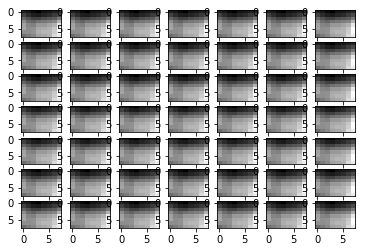

In [14]:
with tf.Session() as sess:
    sess.run(init_op)
    for epoch in range(epochs):
        avg_cost = 0
        total_batch = int(10000 / batch_size)
        for i in range(total_batch):
            batch_x = patches[batch_size*i:batch_size*(i+1), :]
            _, c = sess.run([optimiser, loss],
                            feed_dict={x: batch_x, y: batch_x, data: patches})
            avg_cost += c / total_batch
        print("Epoch:", (epoch + 1), "cost =", "{:.3f}".format(avg_cost))
    saver = tf.train.Saver()
    save_path = saver.save(sess, "model")
    print("Model saved in file: %s" % save_path)
    print("Variables saved!")
    feed_dict = {x: patches[:49, :]}
    classification = sess.run(y_, feed_dict)
    plt.figure()
    for i in range(49):
        ax= plt.subplot(7, 7,i+1)
        im=ax.imshow(classification[i, :].reshape([patchsize, patchsize]), cmap='gray', aspect='auto')

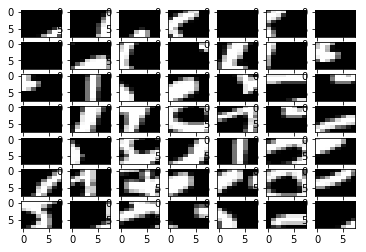

In [20]:
for i in range(49):
    ax= plt.subplot(7, 7,i+1)
    im=ax.imshow(patches[i, :].reshape([patchsize, patchsize]), cmap='gray', aspect='auto')

In [15]:
sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph('model.meta')
saver.restore(sess,tf.train.latest_checkpoint('./'))

In [16]:
weights = sess.run(W1)

In [17]:
weights.shape

(64, 25)

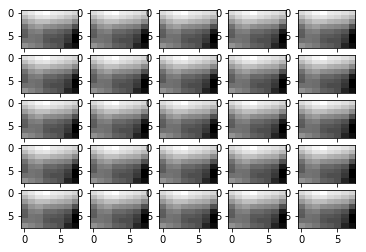

In [18]:
plt.figure()
for i in range(25):
    ax= plt.subplot(5, 5,i+1)
    im=ax.imshow(weights[:, i].reshape([patchsize, patchsize]), cmap='gray', aspect='auto')

In [19]:
sess.close()